In [2]:
from datascience import *
import numpy as np
import pandas as pd
from math import *
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Lesson 35: Regression

Over the last two lessons, you went over regression in Data 8.3x. In these sections, you learned how to calculate the slope and intercept of a line fit to a bivariate sample. For example, using the `baby.csv` dataset, you can use regression to predict birthweight given the gestational age of the baby at birth. 

### Exercise 1

Find the least squares line that predicts birthweight based on the gestational age of a baby. You should use `minimize`, an optimization method in the `datascience` package. Note that you could use standardization (similar to what they did in Data 8.3x, `lec7.ipynb`) but the resulting intercept and slope would be in standardized units, and would need to be transformed in order to be interpretable. 

In [3]:
baby = Table.read_table('baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


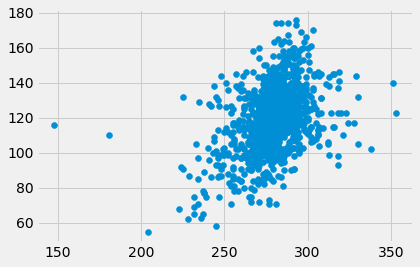

In [4]:
plt.scatter(baby.column(1),baby.column(0))
plt.show()

In [5]:
def mse(any_slope, any_intercept):
    x = baby.column(1)
    y = baby.column(0)
    predicted = any_slope*x+any_intercept
    return np.mean((y-predicted)**2)
minimize(mse) #slope,intercept
slope = minimize(mse)[0]
intercept = minimize(mse)[1]
print(intercept,slope)

-0.07039869065634102 0.4284036994399665


In the context of the data, interpret the intercept and slope. 

**(IN CLASS) Ignore intercept for now, it doesnt really matter, slope is how much the weight will increase given one additional day (on average)**

**The slope of the line is measures the increase in the estimated height per unit increase in weight. The slope is positive, and it is important to note that this does not mean that we think basset hounds get taller if they put on weight. The slope reflects the difference in the average heights of two groups of dogs that are 1 pound apart in weight.**

The slope is 0.428. It seems reasonable to expect this slope to be significantly higher than zero; it makes sense that gestational age would impact birthweight. Let's check using **bootstrapping**. 

In [6]:
def mse_resample(any_slope, any_intercept):
    x = resample.column(1)
    y = resample.column(0)
    predicted = any_slope*x+any_intercept
    return np.mean((y-predicted)**2)

slopes = []

for _ in np.arange(5000):
    resample = baby.sample()
    slopes = np.append(slopes,minimize(mse_resample)[0])
    
    
percentile([2.5,97.5],slopes)

array([0.42512385, 0.43230985])

### Exercise 2

For a baby born at 40 weeks gestational age, what do we expect to be the average birthweight according to this model?

In [7]:
# predict at 40 weeks gesttional age
prediction = slope*40*7+intercept
prediction

119.88263715253429

Using bootstrapping, build a 95% confidence interval around this estimate. Interpret this interval, carefully. 

In [8]:
# predict at 280, and bootstrap, sample with replacement

bw = []
baby40 = baby.where(1, are.equal_to(40*7))
for _ in np.arange(500):
    resample= baby40.sample()
    bw = np.append(bw,minimize(mse_resample)[0]* 280 + minimize(mse_resample)[1])
    
percentile([2.5,97.5],bw)

array([114.9       , 123.77499999])

This is a confidence inteval on the **mean** birthweight for a baby born at 40 weeks. 

### Exercise 3

Suppose a baby is born at 40 weeks. Let's construct a confidence interval for the birthweight of *that baby*. This is different than the confidence interval on the mean birthweight of babies born at 40 weeks. This interval is known as a prediction interval. 

A simple way to find the prediction interval is to sample many times (with replacement) from the observed residuals and add to the predicted birthweight under the linear model. Find the percentiles of these simulations to obtain the interval. 

In [9]:
slope = minimize(mse)[0]
intercept = minimize(mse)[1]
residuals = Table().with_column('Residuals', baby.column(0) - slope*baby.column(1)+ intercept)
residuals_set = []
for _ in np.arange(10000):
    rq = residuals.sample()
    residuals_set = np.append(residuals_set,rq.column(0)+slope*280+intercept)
percentile([2.5,97.5],residuals_set)

array([ 86.14323961, 153.14206551])

It turns out that this method is a little oversimplified. A "more correct" method is below. This requires taking into account the *leverage* of each data point (basically a measure of impact to the model of each data point). 

In [10]:
pred=intercept+slope*150
leverage=1/baby.num_rows + ((baby.column(1)-np.mean(baby.column(1)))**2)/np.sum(((baby.column(1)-np.mean(baby.column(1)))**2))
adjresiduals=residuals/np.sqrt(1-leverage)

bs_all=[]
for _ in np.arange(5000):
    bs_y=(intercept+slope*baby.column(1))+np.random.choice(adjresiduals,size=baby.num_rows,replace=True)
    resample=Table().with_columns("y",bs_y,"x",baby.column(1))
    bs_slope,bs_intercept=minimize(mse_resample)
    bs_residuals=bs_y-(bs_intercept+bs_slope*baby.column(1))
    bs_adjresiduals=bs_residuals/np.sqrt(1-leverage)
    bs_all=np.append(bs_all,150*(slope-bs_slope)+np.random.choice(bs_adjresiduals))

percentile([2.5,97.5],pred+bs_all)

C:\Users\C20Jeffrey.Gerlica\AppData\Local\Continuum\anaconda3\lib\site-packages\datascience\tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


ValueError: invalid __array_struct__